In [2]:
from importlib import reload
import backtest
import order_book
import signal_1
import scipy.odr as odr

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import yfinance as yf
import pickle
import os
import math
from ReferentialData.polygonData import PolygonAPI
from DataAnalysis import DataExtensions
from Filtering.KalmanFilter import KalmanFilter

In [4]:
# Loading "pairs trade" buckets
DIR = r'C:\Users\raymo\OneDrive\Desktop\Ray Stuff\_Cache'
COR_DIR = r'\Users\raymo\OneDrive\Desktop\Playground\Financial-Modelling-Playground\Quant_Trading\Clustering'
with open(os.path.join(COR_DIR, "correlation_buckets_no_shorts.pkl"), "rb") as file:
    BUCKETS = pickle.load(file)

In [5]:
# Concatenating dictionary value lists
UNIVERSE=[]
for i in list(BUCKETS.values()):
    UNIVERSE.extend(i)

In [6]:
colnames = ["Close", "Volume"]
DataLoader = PolygonAPI()
MID_LOADED = False
HIGH_LOADED = False
if not MID_LOADED:
    mid_df = {}
if not HIGH_LOADED:
    high_df = {}
### loading in low frequency data
if len(mid_df) == 0:
    mid_df = DataLoader.getPrices(UNIVERSE, "day", logDir=os.path.join(DIR,"Beta_Callibration"), _parallel=True)
    MID_LOADED = True

### loading in high frequency data
if len(high_df) == 0:
    high_df = DataLoader.getPrices(UNIVERSE, "minute", logDir=DIR, _parallel=True)
    HIGH_LOADED = True


## Analysis of first correlation bucket

In [7]:
BUCKETS

{'AOA': ['AOA', 'SPXS', 'SPXU', 'SH', 'SDS'],
 'AIQ': ['AIQ', 'SQQQ', 'QID', 'PSQ'],
 'AGQ': ['AGQ', 'ZSL'],
 'AGG': ['AGG', 'TTT', 'TYO', 'TMV', 'TBT', 'TBX', 'PST'],
 'ACWX': ['ACWX', 'EPV', 'EFZ', 'EFU'],
 'ACWI': ['ACWI', 'SPXU', 'SPXS', 'SH', 'SDS'],
 'AAXJ': ['AAXJ', 'EUM', 'EEV'],
 'ZSL': ['ZSL', 'SLV', 'SIVR', 'GLTR'],
 'ZROZ': ['ZROZ', 'TMV', 'TTT', 'TBT'],
 'XBI': ['XBI', 'LABD'],
 'YCL': ['YCL', 'YCS'],
 'YINN': ['YINN', 'YANG', 'YXI', 'FXP'],
 'YCS': ['YCS', 'FXY'],
 'YXI': ['YXI', 'XPP', 'KWEB', 'GXC', 'FXI', 'CWEB', 'BKF'],
 'YANG': ['YANG', 'XPP', 'KWEB', 'GXC', 'FXI', 'CWEB', 'BKF'],
 'XT': ['XT', 'HIBS'],
 'XTR': ['XTR', 'SQQQ', 'SPXS', 'SPXU', 'SH', 'SDS', 'QID', 'PSQ'],
 'XSOE': ['XSOE', 'EUM', 'EEV'],
 'XSVM': ['XSVM', 'TWM', 'TZA', 'SRTY', 'SMDD', 'SDD', 'RWM'],
 'XSMO': ['XSMO', 'TZA', 'TWM', 'SRTY', 'SMDD', 'SDD', 'RWM'],
 'XPP': ['XPP', 'FXP'],
 'XNTK': ['XNTK', 'SQQQ', 'SOXS', 'QID', 'PSQ'],
 'XMLV': ['XMLV', 'SMDD'],
 'XMMO': ['XMMO', 'SMDD'],
 'XLG': ['XLG', 

In [8]:
# bucket_mask = lambda price_data: price_data[0] in BUCKETS[list(BUCKETS.keys())[1]]
bucket_mask = lambda price_data: price_data[0] in BUCKETS['VIXY']
hf_bucket = dict(filter(bucket_mask, high_df.items()))
mf_bucket = dict(filter(bucket_mask, mid_df.items()))

### Need to find weighting for positions in portfolio

In [9]:
beta = pd.read_csv(r'C:\Users\raymo\OneDrive\Desktop\Ray Stuff\_Cache\Beta_Callibration\^FTW5000_beta.csv')
beta = beta.loc[:, ~beta.columns.str.contains('^Unnamed')]
beta['Beta'] = [float(x.split(",")[0][1:]) for x in beta['Beta']]
beta = beta[beta.apply(bucket_mask, axis=1)]
beta = beta.set_index("Ticker")
beta = beta.to_dict()['Beta']

import yfinance as yf

bm_ticker = "^FTW5000"
## extract benchmark data 
yf_res = yf.Ticker(bm_ticker)
# get historical market data
hist = yf_res.history(interval="1D", period='10y').reset_index().rename(columns={'Close':bm_ticker,
                                                                                'Date':'timestamp'}).set_index('timestamp')
hist = hist.tz_localize(None)
bm_data = hist[[bm_ticker]]
bm_data



C:\Users\raymo\AppData\Local\Temp\ipykernel_34572\1363384057.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bucket_mask = lambda price_data: price_data[0] in BUCKETS['VIXY']


,^FTW5000
timestamp,
2015-01-02,21665.320312
2015-01-05,21269.060547
2015-01-06,21060.250000
2015-01-07,21301.669922
2015-01-08,21672.390625
...,...
2024-12-24,60506.371094
2024-12-26,60517.531250
2024-12-27,59833.500000


In [10]:
corr = pd.read_csv(r'C:\Users\raymo\OneDrive\Desktop\Ray Stuff\_Cache\Beta_Callibration\pairwise_corr.csv')
corr = corr.loc[:, ~corr.columns.str.contains('^Unnamed')]
bucket_corr_mask = lambda price_data: len(set(price_data[0].split(',')).intersection(set(BUCKETS[list(BUCKETS.keys())[0]])))==2
corr = corr[corr.apply(bucket_corr_mask, axis=1)]
corr = corr.sort_values(by="Cross Correlation")
corr

C:\Users\raymo\AppData\Local\Temp\ipykernel_34572\4063414317.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bucket_corr_mask = lambda price_data: len(set(price_data[0].split(',')).intersection(set(BUCKETS[list(BUCKETS.keys())[0]])))==2


,Ticker Pair,Cross Correlation
7085,"AOA,SPXS",-0.929647
7087,"AOA,SPXU",-0.928230
7130,"AOA,SDS",-0.927236
7126,"AOA,SH",-0.913910
129151,"SPXS,SH",0.978531
128576,"SPXU,SH",0.990202
129164,"SPXS,SDS",0.992771
152082,"SH,SDS",0.993211
128529,"SPXU,SPXS",0.994507
128584,"SPXU,SDS",0.998731


In [78]:
hf_df = pd.DataFrame()
for ticker in hf_bucket:
    if len(hf_df) == 0:
        temp = hf_bucket[ticker].rename(columns={'close':ticker})[['timestamp',ticker]]
        temp['timestamp'] = pd.to_datetime(temp['timestamp'], unit='ms')
        hf_df = temp.set_index('timestamp')
    else:
        temp = hf_bucket[ticker].rename(columns={'close':ticker})[['timestamp',ticker]]
        temp['timestamp'] = pd.to_datetime(temp['timestamp'], unit='ms')
        hf_df = hf_df.join(temp.set_index('timestamp'),
                       how = 'left')
hf_df = hf_df.fillna(method='ffill')
hf_df = hf_df.dropna() ## removes dates where not all components are present
hf_df

C:\Users\raymo\AppData\Local\Temp\ipykernel_34572\2129899211.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  hf_df = hf_df.fillna(method='ffill')


,SVXY,SVIX,VIXY
timestamp,,,
2022-03-30 13:00:00,28.2800,15.06,62.1200
2022-03-30 14:00:00,27.9750,14.80,63.4800
2022-03-30 15:00:00,27.9400,14.67,63.6028
2022-03-30 16:00:00,28.0051,14.79,63.3200
2022-03-30 17:00:00,28.0625,14.84,63.0680
...,...,...,...
2024-12-10 19:00:00,53.4499,29.59,41.6000
2024-12-10 20:00:00,53.2800,29.48,41.8500
2024-12-10 21:00:00,53.2800,29.48,41.7600


In [280]:
get_unixtime(hf_df.index.values[0])

1648645200

In [282]:
import datetime
from importlib import reload
import OptimizationEngine.mipEngine
reload(OptimizationEngine.mipEngine)

daily_dt = 10e3*60*60*24
min_dt = 10e3*60
dt_ratio = daily_dt / min_dt 

import time
def datetime_to_ms_epoch(dt):
    microseconds = time.mktime(dt.timetuple()) * 1000000 + dt.microsecond
    return int(round(microseconds / float(1000)))

def get_unixtime(dt64):
    return dt64.astype('datetime64[s]').astype('int')

def shift(xs, n):
    if n >= 0:
        return np.concatenate((np.full(n, np.nan), xs[:-n]))
    else:
        return np.concatenate((xs[-n:], np.full(-n, np.nan)))
logReturnTransform = lambda df : np.log(df.loc[:,~df.columns.str.contains('timestamp')]) - np.log(df.loc[:,~df.columns.str.contains('timestamp')].shift(1))
def logRetDtDailyTransform(df):
    if type(df.index) == np.datetime64:
        return logReturnTransform(df.loc[:,~df.columns.str.contains('timestamp')]).apply(
            lambda col: np.asarray(col) / get_unixtime(np.asarray(df.index.values - shift(df.index.values, 1))) *dt_ratio)
    else:
        return logReturnTransform(df.loc[:,~df.columns.str.contains('timestamp')]).apply(
            lambda col: np.asarray(col) / np.asarray(df.index.values - shift(df.index.values, 1)) *dt_ratio)

# print('Beta Adjustment on Mid-Frequency is: {0}.'.format(mf_betaAdj))

mf_summary = {}
for data in mf_bucket:
    mu = mf_bucket[data][data].mean()
    std = mf_bucket[data][data].std()
    mu_hf = logRetDtDailyTransform(hf_bucket[data])['close'].mean()
    std_hf = logRetDtDailyTransform(hf_bucket[data])['close'].std()
    mf_summary[data] = {"Mu": mu, "Sigma":std, "Beta":beta[data],
                        "Mu_Min": mu_hf, "Sigma_Min": std_hf}
mf_summary = pd.DataFrame(mf_summary)

mf_summary

c:\Users\raymo\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


,SVXY,SVIX,VIXY
Mu,0.001184,0.001377,-0.003404
Sigma,0.021988,0.043082,0.041122
Beta,-0.002179,-0.000660,0.001791
Mu_Min,0.039361,0.106917,-0.012015
Sigma_Min,9.840623,16.363706,28.675776


c:\Users\raymo\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


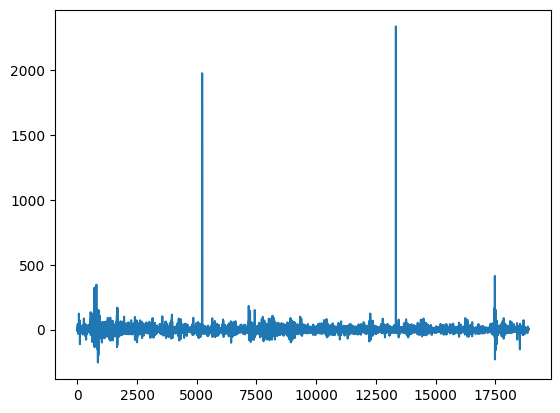

In [283]:
plt.plot(logRetDtDailyTransform(hf_bucket[data])['close'])

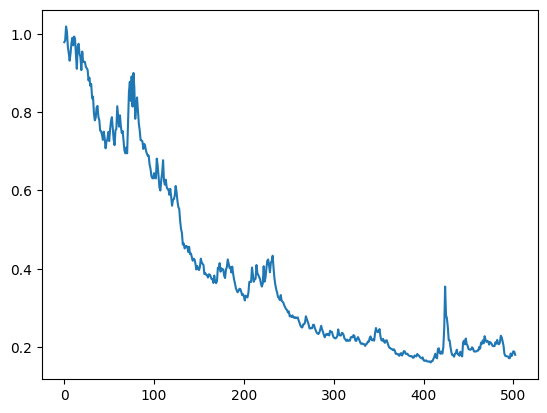

In [284]:
original = np.exp(mf_bucket['VIXY']['VIXY'])
plt.plot(original.cumprod())
# plt.plot(mf_bucket['PSQ'].index, mf_bucket['PSQ']['PSQ'])
# mf_bucket['PSQ']

## Running Ordinary Linear Regression for Weighting

In [285]:
hf_df.to_csv(r'C:\Users\raymo\OneDrive\Desktop\test.csv')

In [286]:
import pandas as pd
from numpy import arange
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import RepeatedKFold#define cross-validation method to evaluate model

def RidgeRegression(X,y):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

    #define model
    model = RidgeCV(alphas=arange(0, 1, 0.01), 
                    cv=cv, 
                    scoring='neg_mean_absolute_error',
                    fit_intercept=False)

    #fit model
    model.fit(X, y)

    #display lambda that produced the lowest test MSE
    print(model.coef_)

    return model


def ElasticNet(X,y, l1=0.5):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    #define model
    model = ElasticNetCV(alphas=arange(0, 1, 0.01), 
                    cv=cv,
                    fit_intercept=False,
                    positive=True,
                    l1_ratio=l1)

    #fit model
    model.fit(X, y)

    #display lambda that produced the lowest test MSE
    print(model.coef_)

    return model

In [287]:
def tls(X, y):
    """
    Performs Total Least Squares regression.

    Args:
        X (numpy.ndarray): Design matrix (n_samples, n_features)
        y (numpy.ndarray): Target vector (n_samples,)

    Returns:
        numpy.ndarray: Estimated coefficients (n_features,)
    """

    # Construct augmented matrix
    A = np.hstack((X, y.reshape(-1, 1)))

    # Perform SVD
    U, S, V = np.linalg.svd(A)

    # Extract coefficients
    Vxy = V[-1, :-1]
    Vyy = V[-1, -1]

    return -Vxy / Vyy

In [288]:
hf_log

,SVXY,SVIX,VIXY
timestamp,,,
2022-03-30 14:00:00,-0.010862,-0.017421,0.021672
2022-03-30 15:00:00,-0.001270,-0.008828,0.001948
2022-03-30 16:00:00,0.002309,0.008141,-0.004441
2022-03-30 17:00:00,0.002029,0.003369,-0.003972
2022-03-30 18:00:00,-0.009956,-0.014258,0.019050
...,...,...,...
2024-12-10 19:00:00,-0.000010,-0.001016,0.000247
2024-12-10 20:00:00,-0.003192,-0.003727,0.005998
2024-12-10 21:00:00,-0.000008,-0.000002,-0.002146


In [289]:
# Define a function (quadratic in our case)
# to fit the data with.
# odr initially assumes a linear function
def f(B, x):
    return B[0] + np.dot(B[1:], x)  # B[0] is the intercept, B[1:] are the slopes

### log returns of high frequency data frame

# neutralizeBeta = lambda dcol: dcol[ticker] - mf_summary[ticker] for ticker in df)
hf_log = logReturnTransform(hf_df)
hf_log = pd.merge_asof(hf_log, logReturnTransform(bm_data), on = 'timestamp').dropna().set_index('timestamp')
components = list(hf_log.columns.values)
components.remove(bm_ticker)
### remove beta from FTW5000
hf_log[components] = hf_log[components].apply(lambda dcol: dcol - mf_summary.loc['Beta', dcol.name] 
                                                    *hf_log[bm_ticker] , axis = 0)
hf_log.drop(bm_ticker, axis=1, inplace=True) ## remove benchmark data
reference_ticker = hf_df.columns[0]
x_temp = hf_log.loc[:, ~hf_log.columns.str.contains(reference_ticker)]
x_temp = -1*x_temp.iloc[1:]


# x1=  np.array(x_temp['SPXS'])
# x2= np.array(x_temp['SPXU'])
# x3 = np.array(x_temp['SH'])
# x4=np.array(x_temp['SDS'])
# x = np.column_stack((x1,x2,x3,x4))
x = np.array(x_temp)
y = np.array(hf_log[reference_ticker].iloc[1:])

#  model fitting.
odr_model = odr.Model(f)
 
# Create a Data object using sample data created.
data = odr.Data(x, y)
 
# # Set ODR with the model and data.
# ordinal_distance_reg = odr.ODR(data, odr_model,
#                                beta0=[0] + [1]*x.shape[1])
 
# # Run the regression.
# out = ordinal_distance_reg.run()
 
# # print the results
# out.pprint()

# ElasticNet(x,y, 0)
coeffs_ = RidgeRegression(x,y).coef_

# # Plot the data and the fit
# plt.scatter(x, y)
# plt.plot(x, out.beta[0] * x + out.beta[1], color='red')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.title('Orthogonal Linear Regression')
# plt.show()

[-0.44612406  0.03076663]


Hurst:  0.4197651341752133


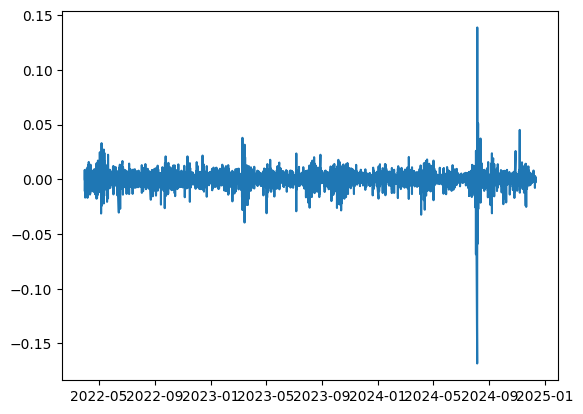

In [290]:
def hurst(ts):
    """Calculates the Hurst Exponent of the time series vector ts"""

    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = np.polyfit(np.log(lags), np.log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0] * 2.0

elementExp = lambda row, coeffs: np.power(np.array(row), coeffs_)
positive_legs = hf_df.loc[:, ~hf_df.columns.str.contains(reference_ticker)]
signal = positive_legs.apply(lambda dr:elementExp(dr, coeffs_).sum(), axis = 1)
signal = signal.add(hf_df[reference_ticker])
raw = pd.DataFrame(positive_legs.apply(lambda dr:elementExp(dr, coeffs_).sum(), axis = 1)).join(hf_df[reference_ticker])
print('Hurst: ', hurst(np.array(signal.resample('1D').agg('last').dropna())))
# plt.hist(signal.pct_change(),bins=100)
plt.plot(signal.pct_change())
# plt.scatter(logReturnTransform(positive_legs.apply(lambda dr:elementExp(dr, coeffs_).sum(), axis = 1)),
#             logReturnTransform(hf_df[reference_ticker]))

In [291]:
hf_df[reference_ticker]

timestamp
2022-03-30 13:00:00    28.2800
2022-03-30 14:00:00    27.9750
2022-03-30 15:00:00    27.9400
2022-03-30 16:00:00    28.0051
2022-03-30 17:00:00    28.0625
                        ...   
2024-12-10 19:00:00    53.4499
2024-12-10 20:00:00    53.2800
2024-12-10 21:00:00    53.2800
2024-12-10 22:00:00    53.3300
2024-12-11 00:00:00    53.3800
Name: SVXY, Length: 9214, dtype: float64

In [292]:
# ### find new beta of signal to benchmark
# from BetaModels.BetaCovFactory import BetaCovFactory
# daily_signal = pd.DataFrame(signal.resample('1D').last().dropna(),
#                             columns=['DailySignal'])
# print(daily_signal)
# bm_ticker = "^FTW5000"

# ## extract benchmark data 
# yf_res = yf.Ticker(bm_ticker)
# info = yf_res.info
# # get historical market data
# hist = yf_res.history(interval="1D", period='5y').rename(columns={'Close':bm_ticker})
# hist = hist.tz_localize(None)
# #hist.index = hist.index.normalize()
# bm_data = hist[[bm_ticker]].rename(columns={'Date':'timestamp'})
# bmFactory = BetaCovFactory(logReturnTransform(bm_data)[1:])
# signalBeta = bmFactory.calculateBeta(logReturnTransform(daily_signal)[1:])[0]
# signalBeta

Signal = pd.DataFrame(signal, columns=['Signal'])
# Signal['timestamp'] = [datetime_to_ms_epoch(ts) for ts in Signal['timestamp']]
Signal

,Signal
timestamp,
2022-03-30 13:00:00,29.713685
2022-03-30 14:00:00,29.411767
2022-03-30 15:00:00,29.378020
2022-03-30 16:00:00,29.441870
2022-03-30 17:00:00,29.498678
...,...
2024-12-10 19:00:00,54.792079
2024-12-10 20:00:00,54.622753
2024-12-10 21:00:00,54.622679


In [294]:
logRetDtDailyTransform(pd.DataFrame(hf_df[reference_ticker]))

DTypePromotionError: The DType <class 'numpy.dtypes.Float64DType'> could not be promoted by <class 'numpy.dtypes.DateTime64DType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.DateTime64DType'>)

In [254]:
plt.scatter(logRetDtDailyTransform(Signal),
            logRetDtDailyTransform(pd.DataFrame(hf_df[reference_ticker]).reset_index()))

UFuncTypeError: ufunc 'divide' cannot use operands with types dtype('float64') and dtype('<m8[ns]')

In [145]:
logReturnTransform(Signal)[1:].Signal

timestamp
2022-03-30 14:00:00   -1.021285e-02
2022-03-30 15:00:00   -1.148062e-03
2022-03-30 16:00:00    2.171021e-03
2022-03-30 17:00:00    1.927648e-03
2022-03-30 18:00:00   -9.363433e-03
                           ...     
2024-12-10 19:00:00    1.463690e-07
2024-12-10 20:00:00   -3.095128e-03
2024-12-10 21:00:00   -1.360194e-06
2024-12-10 22:00:00    9.179681e-04
2024-12-11 00:00:00    9.068002e-04
Name: Signal, Length: 9213, dtype: float64

In [146]:
## Filtering
# filter = KalmanFilter(raw)
reload(KalmanFilter)
names = [0, 'AIQ']#['AIQ',0]
means, covs = KalmanFilter.KalmanFilter.UnivariateKF('Signal', logReturnTransform(Signal)[1:].Signal, 
                                                     np.mean(logReturnTransform(Signal)),
                                                     np.cov(logReturnTransform(Signal))) 
# Create subplots with shared axes
# fig, axes = plt.subplots(1, 2, sharex=True)
# # Plot data on each subplot
# axes[0].plot(Signal.index, means.squeeze())
# axes[1].plot(Signal.index, covs.squeeze())

mean, std = means.squeeze(), np.std(covs.squeeze())

plt.figure(figsize=(15,7))
plt.plot(Signal.index, Signal['Signal'] - mean, 'm', lw=1)
plt.plot(Signal.index, 2 * np.sqrt(covs.squeeze()), 'y', lw=1)
plt.plot(Signal.index, - 2 * np.sqrt(covs.squeeze()), 'c', lw=1)
plt.title('Kalman filter estimate')
plt.legend(['Error: real_value - mean', 'std', '-std'])
plt.xlabel('Day')
plt.ylabel('Value')

C:\Users\raymo\AppData\Local\Temp\ipykernel_34572\3839566073.py:7: RuntimeWarning: Degrees of freedom <= 0 for slice
  np.cov(logReturnTransform(Signal)))
c:\Users\raymo\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\raymo\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


ValueError: The shape of all parameters is not consistent.  Please re-check their values.

In [107]:
covs.squeeze()

array([0.5       , 0.33337777, 0.25008124, ..., 0.00995012, 0.00995012,
       0.00995012])

In [78]:
raw

,0,AIQ
timestamp,,
2019-12-26 14:00:00,75.298205,18.0650
2019-12-26 15:00:00,75.218240,18.0920
2019-12-26 16:00:00,75.124932,18.1200
2019-12-26 20:00:00,74.951610,18.0635
2019-12-27 14:00:00,75.104404,18.1478
...,...,...
2024-12-10 17:00:00,27.303951,39.8900
2024-12-10 18:00:00,27.322122,39.8765
2024-12-10 19:00:00,27.370570,39.7607


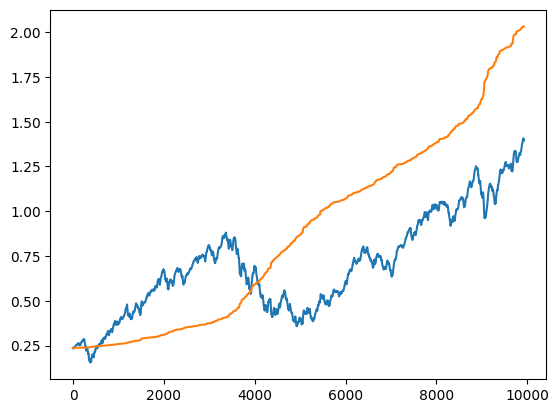

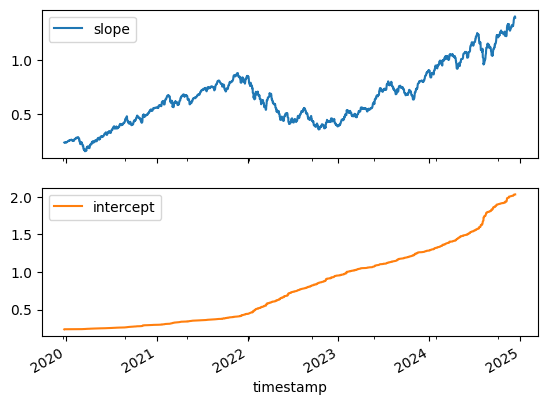

In [79]:
"""
Need to check math on regression on return back to signal level.
logret(Y) = Beta*logret(X) [assume  centered 0]
log(Y) - log(Y') = Beta*(log(X) - log(X'))
log(Y) - log(Y') = log(sum_i x_i^beta_i) - log(sum_i x'_i^beta_i)

"""
plt.plot(state_means)#, state_covs
DataExtensions.draw_slope_intercept_changes(raw, state_means)

[0.23672768 0.23705808 0.237411   ... 1.39690059 1.39533019 1.39427017]


Text(0, 0.5, 'Residuals')

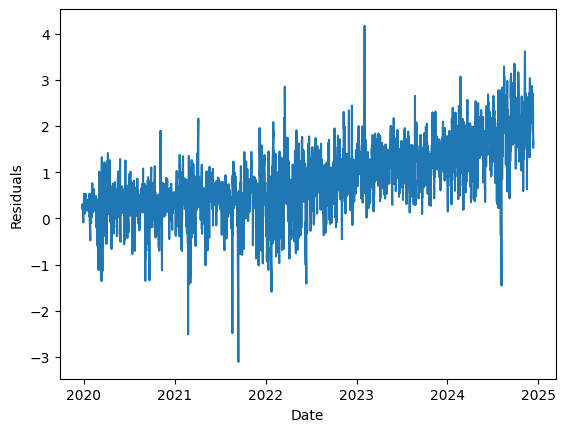

In [80]:
state_means0 = np.array(pd.DataFrame(state_means)[0])
print(state_means0)
resid = raw[names[1]]-raw[names[0]]*state_means0
stdev = []
for i in range(len(resid)):
    stdev.append(math.sqrt(state_covs[i][0][0]))
plt.plot(resid)
plt.xlabel('Date')
plt.ylabel("Residuals")

# adf_test(resid.dropna())

# H, c,  drop = compute_Hc(resid.dropna())
# print('Hurst Exponent', H)

## Portfolio Optimization

In [ ]:
bounds = {'Mu':0, 'Sigma':0, 'Beta':0, 'Mu_Min':0, 'Sigma_Min':0}
MIP = OptimizationEngine.mipEngine.mipEngine()
# MIP._addVariables(mf_summary.columns, var_bounds=(None,None), var_type="INTEGER")
MIP._addConstraints(mf_summary, bounds, var_bounds=(1,None))
MIP._optimize()
#pd.DataFrame(mf_summary)

In [ ]:
raw = raw.reset_index().set_index('timestamp')
raw

In [ ]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
## analysis between adr spread and volume pct
df = signal

df.fillna(method='ffill', inplace=True)
# df['ADR_Vol_Pct'] = df['TSMC34_SA_Volume']/(df['TSMC34_SA_Volume'] +df['TSM_Volume'])
mean = df.mean()
std = df.std()
# df['ADR_Vol_Pct'] = (df['ADR_Vol_Pct'] - mean)/std
# df['ADR_Spread'] = df['TSM_Close'] - df['TSMC34_SA_Close']
# mean = df['ADR_Spread'].mean()
# std = df['ADR_Spread'].std()
# df['ADR_Spread'] = (df['ADR_Spread'] - mean)/std
coint_test_result = coint_johansen(raw, det_order=1, k_ar_diff=0)
tracevalues = coint_test_result.lr1
critical_values = coint_test_result.cvt
for i, (stock1, stock2) in enumerate([list(raw.columns.values)]):
    if (tracevalues[i] > critical_values[:, 1]).all():
        print(f"Pair {i + 1} ({stock1} and {stock2}) is cointegrated.")
    else:
        print(f"Pair {i + 1} ({stock1} and {stock2}) is not cointegrated.")

In [ ]:
import statsmodels.api as sm
# adding the constant term
x = df[['ADR_Spread']].shift(1)[1:]#.tolist()
y = df['ADR_Spread'][1:].tolist()
#x = sm.add_constant(x)
 
# performing the regression
# and fitting the model
result = sm.OLS(y, x).fit()
 
# printing the summary table
print(result.summary())

In [ ]:
result.coef()

In [ ]:

df['ADR_Vol_MA20'] = df['ADR_Vol_Pct'].rolling(20).mean()
df['ADR_1sd_MA20'] = df['ADR_Vol_Pct'].rolling(20).std()
df['primitive_signal'] = df.apply(lambda dr: 1 if dr.ADR_Vol_Pct < dr.ADR_Vol_MA20 - dr.ADR_1sd_MA20 else 0, axis=1).rolling(5).mean()
## add persistence to signal - to optimize
df['Signal'] = [1 if x > 0 else 0 for x in df['primitive_signal']]
df['BuySell'] = df['Signal'] - df['Signal'].shift(1)
df["index"] = pd.to_datetime(df["index"])
df

In [ ]:
BBO = order_book.Book()
for row in df.itertuples():
    if (row.BuySell == 1):
        print('bought spread at ', row.index)
        BBO.addOrder(row.index, "TSM", row.TSM_Close, -100)
        BBO.addOrder(row.index, "TSMC34_SA", row.TSMC34_SA_Close, 150)
    elif (row.BuySell == -1):
        print('sold spread at ', row.index)
        BBO.addOrder(row.index, "TSM", row.TSM_Close, 100)
        BBO.addOrder(row.index, "TSMC34_SA", row.TSMC34_SA_Close, -150)
#BBO.addOrder(df_res.iloc[100]["Date"], "TSM", 300.0, 10)
#BBO.addOrder(df_res.iloc[120]["Date"], "TSM", 250.0, 25)
#BBO.addOrder(df_res.iloc[200]["Date"], "TSM", 350.0, -30)
#BBO.getTickerBook(["TSLA"]).tail(1)#.loc['Quantity']
#BBO.get_history()

#BBO.addOrder(df_res.iloc[50]["Date"], "TSMC34.SA", 300.0, 10)
#BBO.addOrder(df_res.iloc[150]["Date"], "TSMC34.SA", 250.0, -25)

In [ ]:
BBO.getHistoryDf().Date

In [ ]:
df = df.rename(columns={"index":"Date"})
df1 = df[['Date', 'TSMC34_SA_Close']]
df2 = df[['Date', 'TSM_Close']]
df1['Ticker'] = 'TSMC34_SA'
df2['Ticker'] = 'TSM'

df_res = pd.concat([df1.rename(columns={'TSMC34_SA_Close':'Price'}),df2.rename(columns={'TSM_Close':'Price'})])
print(df_res)
#df1.drop('index', inplace=True)
#df_res.rename(columns={'Datetime':'Date'}, inplace=True)
df_res# = df1[['Date', 'Ticker']]
BBO.backfillPnL(df_res)

In [71]:
hist = BBO.getHistoryDf()

In [ ]:
BBO.getTickerBook(['TSM'])

In [ ]:
plt.plot(hist[['PnL']])
plt.show()

In [ ]:
print(hist)

In [ ]:
BBO.get_books()

In [ ]:
hist